# Intro

The goal of this document is simply to explore the code within RITSAR and give step by step visualization to the ongoing processes. 

TODO:
- Give a better text description as to what is going on at each step

In [1]:
#Generic Import statements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pathlib
import scipy.io as sio
%matplotlib notebook
#%matplotlib inline

In [2]:
#First, we need to find and bring our data files into memory
#The data file we will be using is in the data folder, specifically data/AFRL/pass1
#We have to start from the 'parent' directory which is '.'
directory='./data/AFRL/pass1'

#Our AFRL file reading code requires a starting azimuth and polarization
#I leave the details of file naming convention to the reader, let's cheat
subfile1='HH/data_3dsar_pass1_az001_HH.mat'
subfile2='HH/data_3dsar_pass1_az002_HH.mat'
subfile3='HH/data_3dsar_pass1_az003_HH.mat'
subfile4='HH/data_3dsar_pass1_az004_HH.mat'

#
name=pathlib.Path(directory + '/' + subfile1)
print(name)

data\AFRL\pass1\HH\data_3dsar_pass1_az001_HH.mat


In [3]:
# read the .mat files 

file1data=sio.loadmat(pathlib.Path(directory + '/' + subfile1), simplify_cells=True)['data']
file2data=sio.loadmat(pathlib.Path(directory + '/' + subfile2), simplify_cells=True)['data']
file3data=sio.loadmat(pathlib.Path(directory + '/' + subfile3), simplify_cells=True)['data']
file4data=sio.loadmat(pathlib.Path(directory + '/' + subfile4), simplify_cells=True)['data']

In [4]:
#Now let's explore what the data looks like
for key in file1data.keys():
    try:
        print(key, '  ', file1data[key].shape)
    except:
        print(key, '  ', 'No shape for this ')
        

fp    (424, 117)
freq    (424,)
x    (117,)
y    (117,)
z    (117,)
r0    (117,)
th    (117,)
phi    (117,)
af    No shape for this 


In [5]:
print(file1data['af'].keys())
#these aren't used in our code

dict_keys(['r_correct', 'ph_correct'])


<IPython.core.display.Javascript object>


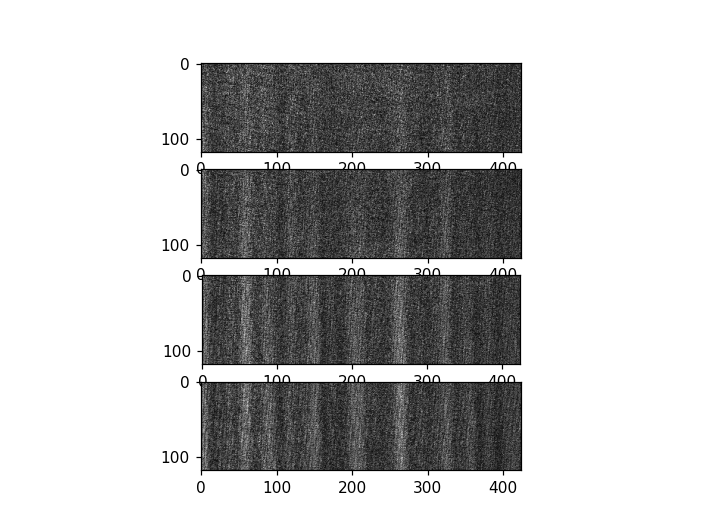

In [6]:
#now it's time to join this data into a phase history
#first, let's look at the sub components
keys=file1data.keys()
key='fp' if 'fp' in keys else 'fq' #Used for compatibility
phs_tmp1= file1data[key].T
phs_tmp2= file2data[key].T
phs_tmp3= file3data[key].T
phs_tmp4= file4data[key].T

fig,ax=plt.subplots(4,1)

ax[0].imshow(np.abs(phs_tmp1),cmap='gray')
ax[1].imshow(np.abs(phs_tmp2),cmap='gray')
ax[2].imshow(np.abs(phs_tmp3),cmap='gray')
ax[3].imshow(np.abs(phs_tmp4),cmap='gray')

<IPython.core.display.Javascript object>


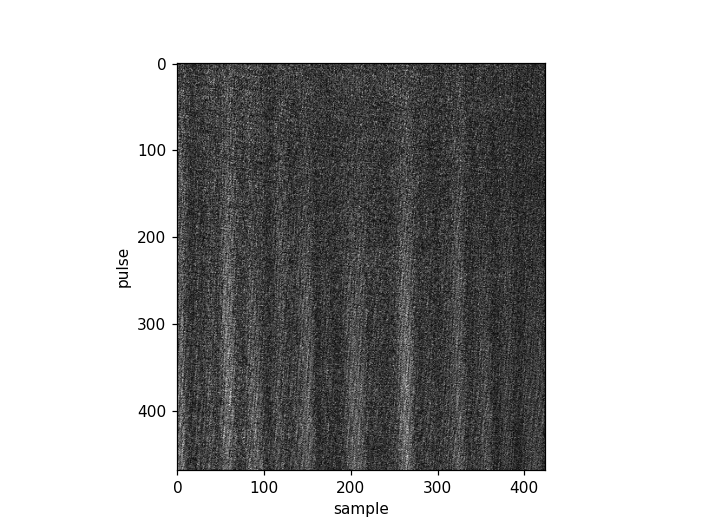

Text(0.5, 0, 'sample')

In [7]:
# join the phase histories ‐--------------, -------‐--------
phs=np.vstack([phs_tmp1,phs_tmp2,phs_tmp3,phs_tmp4])
plt.figure()               
plt.imshow(np.abs(phs),cmap='gray')
plt.ylabel('pulse')
plt.xlabel('sample')


<IPython.core.display.Javascript object>


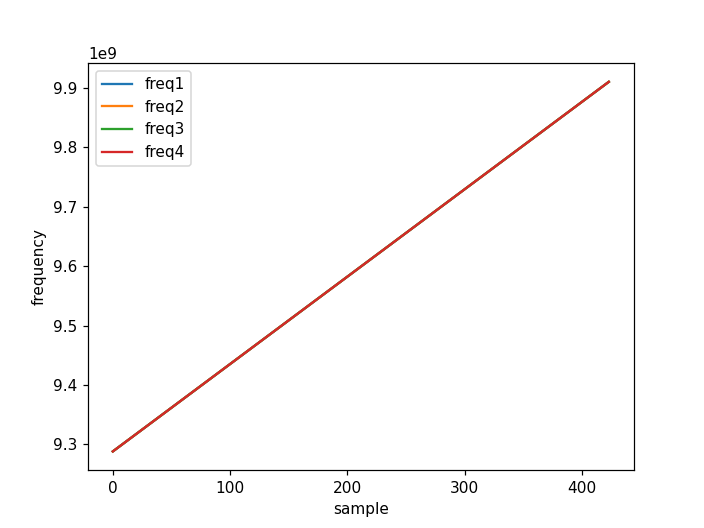

Text(0, 0.5, 'frequency')

In [8]:
#explore the other parameters-----------------------------
freq1= np.float64(file1data['freq'])
freq2= np.float64(file2data['freq'])
freq3= np.float64(file3data['freq'])
freq4= np.float64(file4data['freq'])

plt.figure()
plt.plot(freq1,label='freq1')
plt.plot(freq2,label='freq2')
plt.plot(freq3,label='freq3')
plt.plot(freq4,label='freq4')
plt.legend()
plt.xlabel('sample')
plt.ylabel('frequency')

<IPython.core.display.Javascript object>


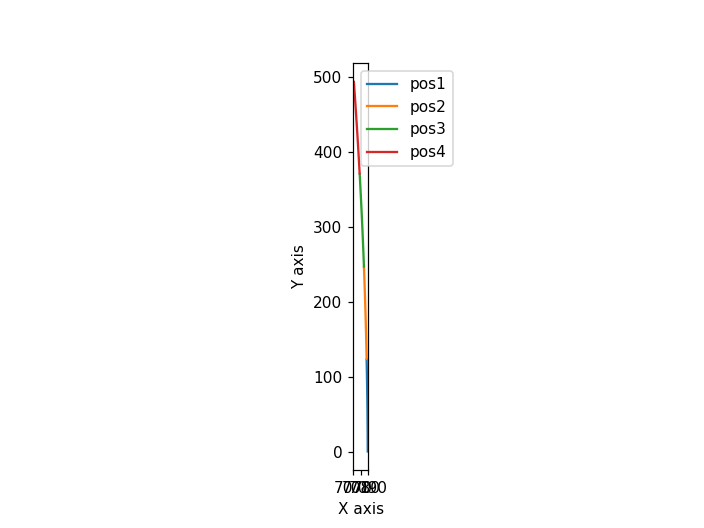

In [9]:
#now let's look at flight position---------------------------------------‐------------
pos1 = np.vstack((file1data['x'], file1data['y'], file1data['z'])).T
pos2 = np.vstack((file2data['x'], file2data['y'], file2data['z'])).T
pos3 = np.vstack((file3data['x'], file3data['y'], file3data['z'])).T
pos4 = np.vstack((file4data['x'], file4data['y'], file4data['z'])).T


fig,ax=plt.subplots()
ax.plot(pos1[:,0],pos1[:,1],label='pos1')
ax.plot(pos2[:,0],pos2[:,1],label='pos2')
ax.plot(pos3[:,0],pos3[:,1],label='pos3')
ax.plot(pos4[:,0],pos4[:,1],label='pos4')
plt.gca().set_aspect('equal', adjustable='box')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

ax.legend()


<IPython.core.display.Javascript object>


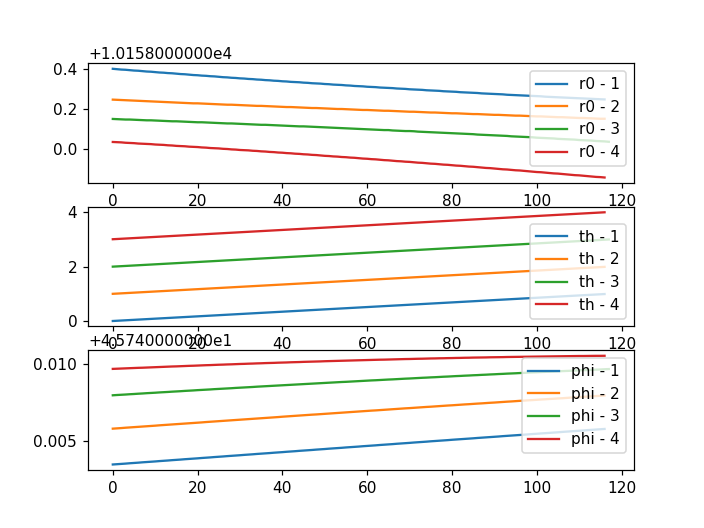

In [10]:
#now let's look at r0, th, and phi
#I'm not seeing these getting used in image formation----------------
#I see the same variable names, but they don't come from platform

#r0
fig,ax=plt.subplots(3,1)
ax[0].plot(file1data['r0'], label="r0 - 1")
ax[0].plot(file2data['r0'], label="r0 - 2")
ax[0].plot(file3data['r0'], label="r0 - 3")
ax[0].plot(file4data['r0'], label="r0 - 4")
ax[0].legend()

#th
ax[1].plot(file1data['th'], label="th - 1")
ax[1].plot(file2data['th'], label="th - 2")
ax[1].plot(file3data['th'], label="th - 3")
ax[1].plot(file4data['th'], label="th - 4")
ax[1].legend()

#phi
ax[2].plot(file1data['phi'], label="phi - 1")
ax[2].plot(file2data['phi'], label="phi - 2")
ax[2].plot(file3data['phi'], label="phi - 3")
ax[2].plot(file4data['phi'], label="phi - 4")
ax[2].legend()




In [11]:
#these first two parameters are easy
c=299792458.0
npulses = phs.shape[0]
nsamples = phs.shape[1]

#looks like we need to get the illusive f_0, the center frequency, which wasn't a parameter we got from the data. 
#The code does a linear regression to get this, but lets see how close we get with the average of max and min
freq=freq1
f_1=(np.max(freq)+np.min(freq))/2
print(f_1)


from scipy.stats import linregress
B_IF        = freq.max()-freq.min()
delta_t     = 1.0/B_IF
t           = np.linspace(-nsamples/2, nsamples/2, nsamples)*delta_t

chirprate, f_0, r, p, s\
            = linregress(t, freq)
print(f_0)

print('it appears taking the average is close, but not the same')

9599260672.0
9599260894.188679
it appears taking the average is close, but not the same


<IPython.core.display.Javascript object>


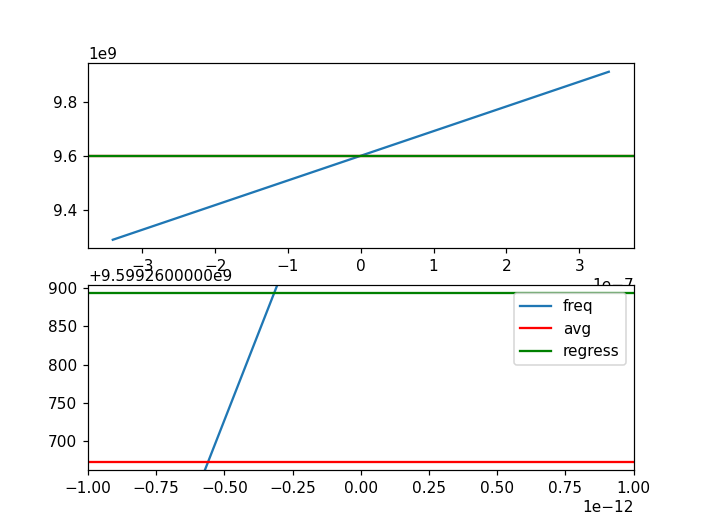

In [12]:
#let's take a closer look at what's going on here
fig,ax=plt.subplots(2,1)
ax[0].plot(t,freq,label='freq')
ax[0].axhline(f_1,label='avg',color='r')
ax[0].axhline(f_0,label='regress',color='g')

x1=-1e-12
x2=1e-12
y1=np.min([f_1,f_0])-10
y2=np.max([f_1,f_0])+10

# Make the zoom-in plot:
ax[1].plot(t,freq,label='freq')
ax[1].axhline(f_1,label='avg',color='r')
ax[1].axhline(f_0,label='regress',color='g')

ax[1].set_xlim(x1, x2)
ax[1].set_ylim(y1, y2)
#plt.xticks(visible=False)
#plt.yticks(visible=False)
#plt.draw()
#plt.show()

ax[1].legend()


In [13]:
#getting position is easy----------,,,,----------
pos=np.vstack([pos1, pos2, pos3, pos4])
pos.shape

(469, 3)

<IPython.core.display.Javascript object>


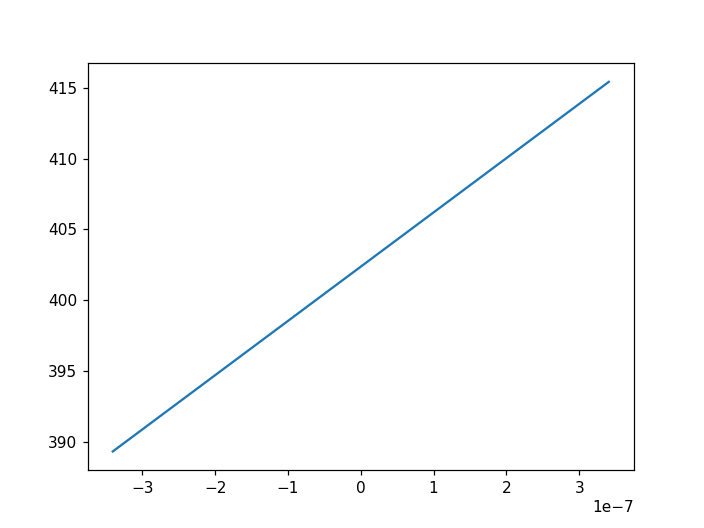

[7084.1978   247.40337 7276.0503 ]


In [14]:
#now it's time for k space items‐-----------------------
k_r=4*np.pi*freq/c #units of meters
plt.figure()    
plt.plot(t,k_r)

#R_c is easy, it's just the middle of the aperture
#todo:put R_c as a vector on the plot for flight path
if np.mod(npulses,2)>0:
    R_c = pos[npulses//2]
else:
    R_c = np.mean(
        pos[npulses//2-1:npulses//2+1],
        axis = 0)
print(R_c)

In [15]:
# now it's time for the hardest part of all of this---------------------
# figuring out the image plane characteristics

# to keep with the example, I'll use res_factor, upsample, and aspect
# upsample triggers the strict use of a power of 2 which
# is equal or larger to the current number of samples/pulses
nu= 2**int(np.log2(nsamples)+bool(np.mod(np.log2(nsamples),1)))
nv= 2**int(np.log2(npulses)+bool(np.mod(np.log2(npulses),1)))
print("number of samples: ", nsamples)
print("number of pulses: ", npulses)
print("pixels in u direction", nu)
print("pixels in v direction", nv)

number of samples:  424
number of pulses:  469
pixels in u direction 512
pixels in v direction 512


In [16]:
# res factor determines how much of the image will lie in the grid
res_factor=1.4 #from the example
aspect=1 #from the example

# delta_r originally from platform calcs but needed here first
# delta_r is the theoretical range resolution limit
delta_r = c/(2*B_IF) #speed of light over double the bandwidth
du = delta_r*res_factor*nsamples/nu
aspect=aspect if aspect else 1.0
dv = aspect*du
#Define range and cross-range locations
u = np.arange(-nu/2, nu/2)*du
v = np.arange(-nv/2, nv/2)*dv

#Derive image plane spatial frequencies
#both of these are in units if Cycles per meter
k_u = 2*np.pi*np.linspace(-1.0/(2*du), 1.0/(2*du), nu)
k_v = 2*np.pi*np.linspace(-1.0/(2*dv), 1.0/(2*dv), nv)


#not needed for polar formatting, great for display though
#Represent u and v in (x,y,z)
[uu,vv] = np.meshgrid(u,v)
#uu = uu.flatten(); vv = vv.flatten()


<IPython.core.display.Javascript object>


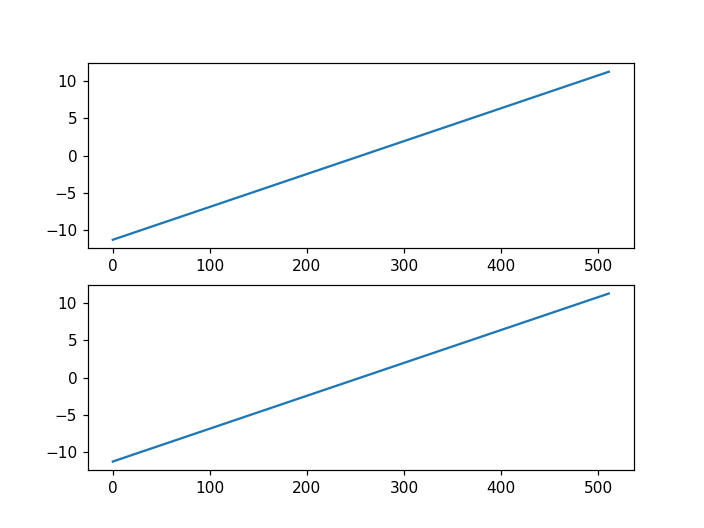

In [17]:
#let's visualize some things we've now done
fig,ax=plt.subplots(2,1)
ax[0].plot(k_u)
ax[1].plot(k_v)


In [18]:
# not used in polar formating, but fun to see
# removed to save notebook size
#fig,ax=plt.subplots(2,1)
#a0=ax[0].imshow(uu)
#ax[0].set_title('u coordinate for bp')
#fig.colorbar(a0, ax=[ax[0]], location = 'right') 
#a1=ax[1].imshow(vv)
#ax[1].set_title('v coordinate for bp')                
#fig.colorbar(a1, ax=[ax[1]], location = 'right')



In [19]:
#uu = uu.flatten(); vv = vv.flatten()

#fig,ax=plt.subplots(2,1)
#ax[0].plot(uu)
#ax[1].plot(vv)


In [20]:
# #determine the vector directions of u and v---------------------------------
n_hat = np.array([0,0,1])
print(R_c/np.linalg.norm(R_c))
v_hat = np.cross(n_hat, R_c)/np.linalg.norm(np.cross(n_hat, R_c))
u_hat = np.cross(v_hat, n_hat)/np.linalg.norm(np.cross(v_hat, n_hat))

print(v_hat)#almost y direction
print(u_hat)#almost x direction


[0.69739074 0.02435517 0.7162773 ]
[-0.03490199  0.99939074  0.        ]
[ 0.99939074  0.03490199 -0.        ]


In [21]:
#Compute x and y unit vectors. x defined to lie along R_c.
#z = np.cross(vec[0], vec[-1]); z =z/np.linalg.norm(z)
print(R_c)
u_hat = (R_c-np.dot(R_c,n_hat)*n_hat)/\
        np.linalg.norm((R_c-np.dot(R_c,n_hat)*n_hat))
v_hat = np.cross(u_hat,n_hat)

print(v_hat)#negative y direction?
print(u_hat)#almost x direction


[7084.1978   247.40337 7276.0503 ]
[ 0.03490199 -0.99939074  0.        ]
[0.99939074 0.03490199 0.        ]


In [22]:
#we finish building the image plane dictionary by saving it
img_plane =\
    {
    'n_hat'     :   n_hat,
    'u_hat'     :   u_hat,
    'v_hat'     :   v_hat,
    'du'        :   du,
    'dv'        :   dv,
    'u'         :   u,
    'v'         :   v,
    'k_u'       :   k_u,
    'k_v'       :   k_v,
#    'pixel_locs':   pixel_locs # 3 x N_pixel array specifying x,y,z location
                               # of each pixel
    }

In [23]:
print(img_plane['n_hat'])
print(img_plane['u_hat'])
print(img_plane['v_hat'])
print(img_plane['du'])
print(img_plane['dv'])

[0 0 1]
[0.99939074 0.03490199 0.        ]
[ 0.03490199 -0.99939074  0.        ]
0.2792367434547702
0.2792367434547702


# Begin polar formatting

In [24]:
#Compute k_xi offset
psi = np.pi/2-np.arccos(np.dot(R_c,n_hat)/np.linalg.norm(R_c))
k_ui = k_u + 4*np.pi*f_0/c*np.cos(psi)
#I'm not sure what this is for.
print(psi)
print(np.cos(psi))
print(4*np.pi*f_0/c*np.cos(psi))
#so we've shifted our range direction frequency space based on graze/squint at center


0.7984527968362254
0.6978157706165373
280.78101309689043


<IPython.core.display.Javascript object>


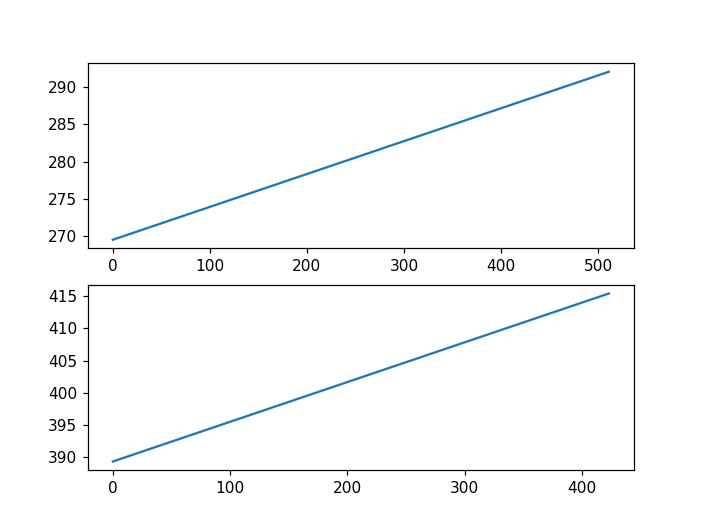

In [25]:
#display the new k_ui and the 
fig,ax = plt.subplots(2,1)
ax[0].plot(k_ui) 
#label this
ax[1].plot(k_r)
#label this 4*pi*freq/c


In [26]:
u_hat 

array([0.99939074, 0.03490199, 0.        ])

In [27]:
#Compute x and y unit vectors. x defined to lie along R_c.
#z = np.cross(vec[0], vec[-1]); z =z/np.linalg.norm(z)
#u_hat = (R_c-np.dot(R_c,n_hat)*n_hat)/\
#        np.linalg.norm((R_c-np.dot(R_c,n_hat)*n_hat))
#v_hat = np.cross(u_hat,n_hat)

#v_hat = np.cross(n_hat, R_c)/np.linalg.norm(np.cross(n_hat, R_c))
#u_hat = np.cross(v_hat, n_hat)/np.linalg.norm(np.cross(v_hat, n_hat))


#Compute r_hat, the diretion of k_r, for each pulse
r_norm = np.linalg.norm(pos,axis=1)
r_norm = np.array([r_norm]).T
r_norm = np.tile(r_norm,(1,3))
r_hat = pos/r_norm #unit vector of direction from scene center to platform at each pulse

In [28]:
#Convert to matrices to make projections easier
r_hat = np.asmatrix(r_hat)
u_hat = np.asmatrix([u_hat])
v_hat = np.asmatrix([v_hat])

#honestly not sure if this step does anything
#matrix multiplication works just fine if you have the shape already

In [29]:
k_r.shape 

(424,)

In [30]:
k_matrix= np.asmatrix(k_r)
k_matrix.shape 


(1, 424)

<IPython.core.display.Javascript object>


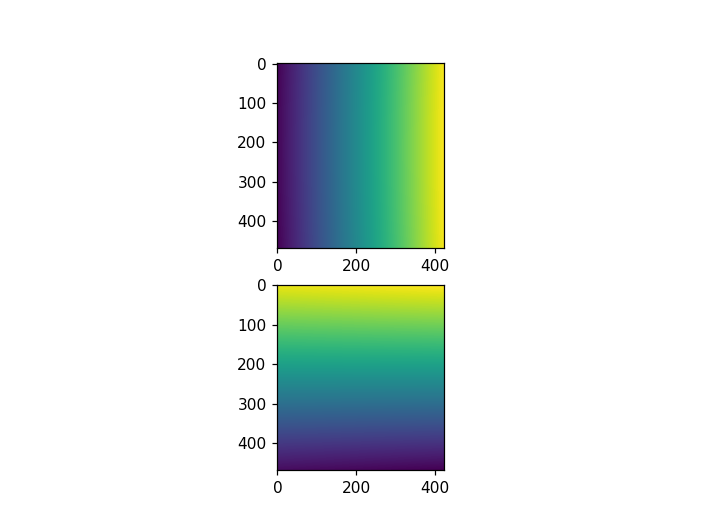

289.88378863380916 271.5015953033375
10.09670277857856 -10.095420144258698


In [31]:
#Compute kx and ky meshgrid
ku = r_hat*u_hat.T*k_matrix; ku = np.asarray(ku)
kv = r_hat*v_hat.T*k_matrix; kv = np.asarray(kv)

fig, ax= plt.subplots(2,1)
ax[0].imshow(ku)
ax[1].imshow(kv)
print(ku.max(), ku.min())
print(kv.max(), kv.min())




In [32]:
def taylor(nsamples, S_L=43):
    xi = np.linspace(-0.5, 0.5, nsamples)
    A = 1.0/np.pi*np.arccosh(10**(S_L*1.0/20))
    n_bar = int(2*A**2+0.5)+1
    sigma_p = n_bar/np.sqrt(A**2+(n_bar-0.5)**2)
    
    #Compute F_m
    m = np.arange(1,n_bar)
    n = np.arange(1,n_bar)
    F_m = np.zeros(n_bar-1)
    for i in m:
        num = 1
        den = 1
        for j in n:
            num = num*\
            (-1)**(i+1)*(1-i**2*1.0/sigma_p**2/(\
                            A**2+(j-0.5)**2))
            if i!=j:
                den = den*(1-i**2*1.0/j**2)
            
        F_m[i-1] = num/den
    
    w = np.ones(nsamples)
    for i in m:
        w += F_m[i-1]*np.cos(2*np.pi*i*xi)
    
    w = w/w.max()          
    return(w)

#Create taylor windows
win1 = taylor(int(phs.shape[1]), S_L = 20)
win2 = taylor(int(phs.shape[0]), S_L = 20)


<IPython.core.display.Javascript object>


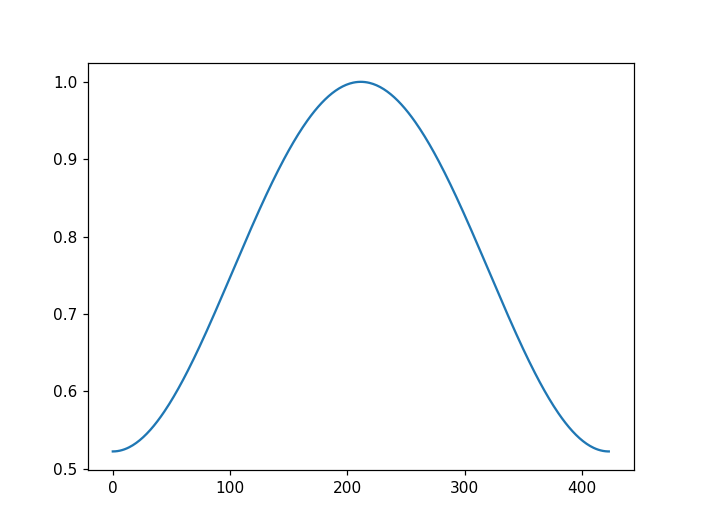

In [33]:
#show what taylor weighting looks like
plt.figure()
plt.plot(win1)



In [34]:
prnt=100

#Radially interpolate kx and ky data from polar raster
#onto evenly spaced kx_i and ky_i grid for each pulse
rad_interp = 0j*np.zeros([npulses,nu])
ky_new = np.zeros([npulses,nu])
for i in range(npulses):
    if prnt:
        if i%prnt==0:
            print('range interpolating for pulse %i'%(i+1))
    rad_interp[i,:] = np.interp(k_ui, ku[i,:], phs[i,:]*win1,
        left = 0, right = 0)
    ky_new[i,:] = np.interp(k_ui, ku[i,:], kv[i,:])  


range interpolating for pulse 1
range interpolating for pulse 101
range interpolating for pulse 201
range interpolating for pulse 301
range interpolating for pulse 401


In [35]:
np.random.randint(10)  

2

<IPython.core.display.Javascript object>


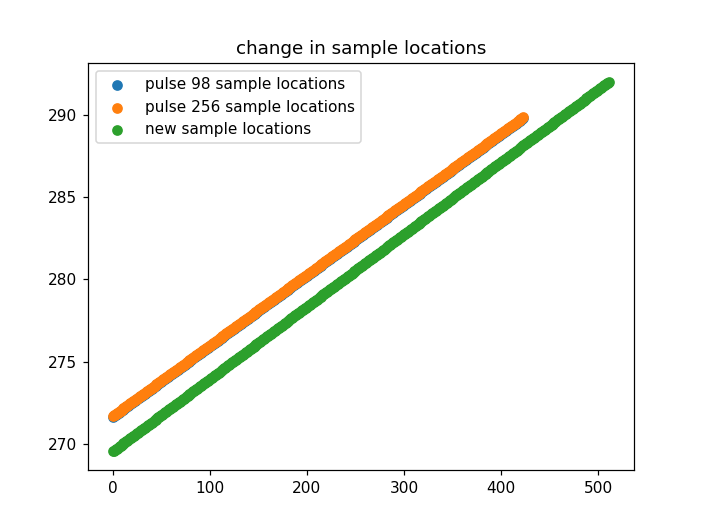

Text(0.5, 1.0, 'change in sample locations')

In [36]:
#this really needs an explanation of what interp is doing--------
#interpolation is used to resample the signal data at new sample locations
plt.figure()
pulsenum1,pulsenum2=np.random.randint(npulses,size=2)
plt.scatter(np.arange(len(ku[pulsenum1,:])), ku[pulsenum1,:], label='pulse %d sample locations' %pulsenum1) #
plt.scatter(np.arange(len(ku[pulsenum2,:])), ku[pulsenum2,:], label='pulse %d sample locations' %pulsenum2) #
plt.scatter(np.arange(len(k_ui)), k_ui, label='new sample locations') #
plt.legend() 
plt.title('change in sample locations')

#as you can see in the figure, interp is expanding the range of data while sampling at about the same density


<IPython.core.display.Javascript object>


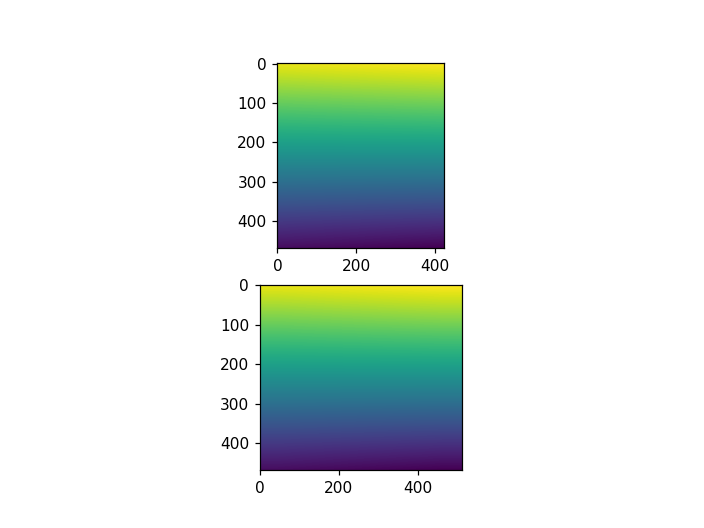

10.09670277857856 -10.095420144258698
10.09670277857856 -10.095420144258698


In [37]:
#also important to show kv vs ky_new
fig, ax= plt.subplots(2,1)
ax[0].imshow(kv)
ax[1].imshow(ky_new)
print(kv.max(), kv.min())
print(ky_new.max(), ky_new.min()) 


In [38]:
#Interpolate in along track direction to obtain polar formatted data
polar = 0j*np.zeros([nv,nu])
isSort = (ky_new[npulses//2, nu//2] < ky_new[npulses//2+1, nu//2])
#isSort seems like a flag to ensure u_hat is in the right direction, but we found earlier the codeisn't consistent with left vs right hand cross product
#TODO: fix left vs right cross product, figure out if it's a left looking vs right looking problem
if isSort:
    for i in range(nu):
        if prnt:
            if i%prnt==0:
                print('cross-range interpolating for sample %i'%(i+1))
        polar[:,i] = np.interp(k_v, ky_new[:,i], rad_interp[:,i]*win2,
            left = 0, right = 0)
else:
    for i in range(nu):
        if prnt:
            if i%prnt==0:
                print('cross-range interpolating for sample %i'%(i+1))
        polar[:,i] = np.interp(k_v, ky_new[::-1,i], 
            rad_interp[::-1,i]*win2, left = 0, right = 0)  
            
phs_polar=np.nan_to_num(polar)


cross-range interpolating for sample 1
cross-range interpolating for sample 101
cross-range interpolating for sample 201
cross-range interpolating for sample 301
cross-range interpolating for sample 401
cross-range interpolating for sample 501


<IPython.core.display.Javascript object>


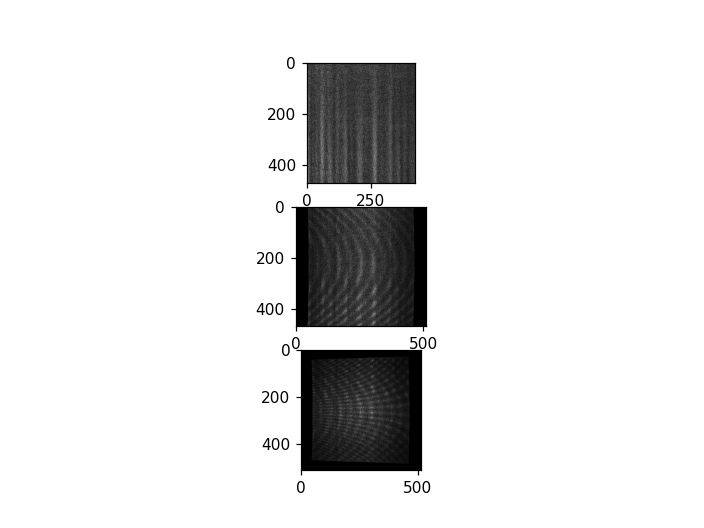

In [39]:
#show the before, during, and after interpolation data
fig, ax= plt.subplots(3,1)
ax[0].imshow(np.abs(phs),cmap='gray')
ax[1].imshow(np.abs(rad_interp),cmap='gray')
ax[2].imshow(np.abs(polar),cmap='gray')


<IPython.core.display.Javascript object>


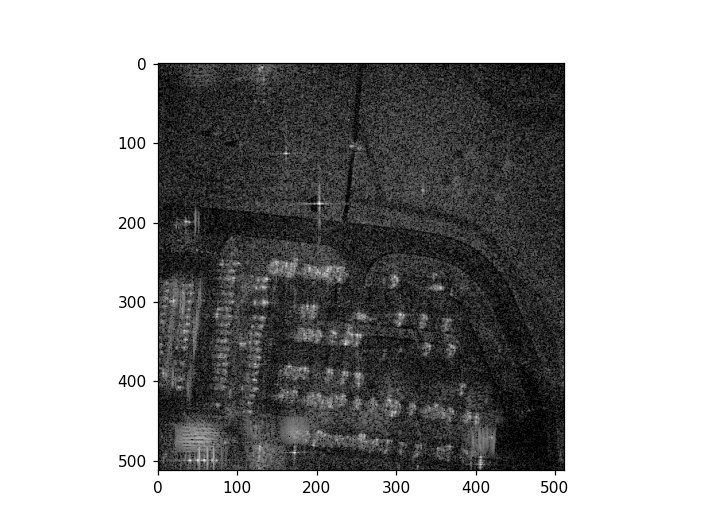

In [40]:
plt.figure()
shift1=np.fft.fftshift(phs_polar)
gmi=np.fft.fft2(shift1)
img=np.fft.ifftshift(gmi)
pre_scale=np.abs(img)

dB_scale=[-30,0]
img = 10*np.log10(np.abs(img)/np.abs(img).max())
img[img == -np.inf] = dB_scale[0]

plt.imshow(img,cmap=cm.Greys_r, vmin = dB_scale[0], vmax = dB_scale[-1])

